In [1]:
%load_ext autoreload

import numpy as np
import numpy.random as npr
import torch
import scipy as sp
from scipy import interpolate
from collections import defaultdict

import json
import pandas as pd
import os
from tqdm import tqdm
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
plt.style.use('bmh')
from matplotlib import cm
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

import dmc2gym

import pickle as pkl
import itertools
import operator
from collections import namedtuple
from glob import glob
import textwrap

import os
import yaml

import sys
# sys.path.append('../batch')
# %autoreload 2
# %aimport bcq

import omegaconf
from omegaconf import OmegaConf

from mve.analysis import plot_ac_exp

from IPython.display import display
%matplotlib inline

In [2]:
def sweep_summary(root):
    configs = {}
    all_summary = []
    for d in glob(f'{root}/*/'):
        eval_f = f'{d}/eval.csv'
        try:
            eval_df = pd.read_csv(eval_f)
        except:
            continue
        print
#         last_eval_rew = eval_df.episode_reward.values[-10:].mean()
        last_eval_rew = eval_df.episode_reward.values[-1]
        best_eval_rew = eval_df.episode_reward.values.max()
        fname = f'{d}/config.yaml'
        if not os.path.exists(fname):
            fname = f'{d}/.hydra/config.yaml'
            assert os.path.exists(fname)
        config = OmegaConf.load(fname)
        configs[d] = config
        fname = f'{d}/overrides.yaml'
        if not os.path.exists(fname):
            fname = f'{d}/.hydra/overrides.yaml'
            assert os.path.exists(fname)
        overrides = OmegaConf.load(fname)
        summary = dict(x.split('=') for x in overrides)
        summary['best_eval_rew'] = best_eval_rew
        summary['last_eval_rew'] = last_eval_rew
        summary['d'] = d
        summary['env_cfg'] = summary['env_cfg'][5:-1]
        all_summary.append(summary)
    
    if len(all_summary) == 0:
        print('No experiments with eval data found.')
        return [None]*4
        
    all_summary = pd.DataFrame(all_summary)
    for col in all_summary.columns:
        if col != 'env' and col != 'env_cfg' and len(all_summary[col].unique()) == 1:
            all_summary.drop(col,inplace=True,axis=1)

    filt = ['env_cfg', 'env', 'seed']
    groups = [x.split('=')[0] for x in overrides]
    groups = [x for x in groups if x not in filt]
    groups = list(set(groups) & set(all_summary.columns))
    groups = ['env_cfg'] + groups
    groups = all_summary.groupby(groups)

    return all_summary, groups, groups.agg(['mean', 'std']), configs

def plot_rew(root, ax=None, label=None):
    if ax is None:
        nrow, ncol = 1, 1
        fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
        ax.set_xlabel('1k Updates')
    
    try:
        eval_df = pd.read_csv(f'{root}/eval.csv')
    except:
        return
    l, = ax.plot(eval_df.step/1000, eval_df.episode_reward, label=label)

def plot_rew_list(ds, title=None, ax=None):
    nrow, ncol = 1, 1
    if ax is None:
        fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    ax.set_xlabel('1k Updates')
#     ax.set_ylim(0, 1000)
    if title is not None:
        ax.set_title(title)
    for d in ds:
        label = d.split('/')[-2]
        plot_rew(d, ax=ax, label=label)
    ax.legend()

def plot_all_rew(root):
    nrow, ncol = 1, 1
    fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    ax.set_xlabel('1k Updates')
    title = '/'.join(root.split('/')[-3:])
    ax.set_title(title)
#     ax.set_ylim(0, 1000)
    for d in glob(f'{root}/*/'):
        label = d.split('/')[-2]
        plot_rew(d, fig=fig, label=label)
    ax.legend()

def plot_agg(df, agg, ncol=4):
    nrow = int(np.ceil(len(agg)/ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow))
    axs = axs.ravel()
    for ax, (r, sub_df) in zip(axs, agg.iterrows()):
        if isinstance(r, str):
            r = [r]
        I = df.index == df.index
        for k, v in zip(agg.index.names, r):
            I = I & (df[k] == v)
        df_I = df[I]
        title = '.'.join([f'{k}={v}' for k,v in zip(agg.index.names, r)])
        title = title.replace('agent.params.', '').replace('model.params.', '').replace('env_cfg', 'env')
        title = '\n'.join(textwrap.wrap(title, 45))
        plot_rew_list(df_I.d.values, title=title, ax=ax)
    fig.tight_layout()

def plot_ablation(
    groups, title, xmax=None,
    save=None, lw=3,
    xlabel='Timestep', ylabel='Reward',
    legend=False, sac_lim=None
):
    fig, ax = plt.subplots(1, 1, figsize=(4.5,3))

    for group in groups:
        all_df = []
        min_step = None
        for root in group['roots']:
            eval_f = f'{root}/eval.csv'
            df = pd.read_csv(eval_f)
            if min_step is None or max(df['step']) < min_step:
                min_step = max(df['step'])
            df['f'] = eval_f
            all_df.append(df)

        step_interp = np.linspace(0, min_step, num=20)
        all_df_interp = []
        for df in all_df:
            rew_interp = np.interp(step_interp, df['step'], df['episode_reward'])
            df_interp = pd.DataFrame({'step': step_interp, 'rew': rew_interp})
            all_df_interp.append(df_interp)
        all_df_interp = pd.concat(all_df_interp)
        label = group['tag'] if legend else None
        if 'color' in group:
            sns.lineplot(x='step', y='rew', data=all_df_interp,
                         ax=ax, linewidth=lw, label=label, color=group['color'])
        else:
            sns.lineplot(x='step', y='rew', data=all_df_interp,
                         ax=ax, linewidth=lw, label=label)
                
    ax.axhline(sac_lim, lw=lw, linestyle='--', color='k')

    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if xmax is not None:
        ax.set_xlim(0, xmax)

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Reward')
    ax.set_title(title)
    fig.tight_layout()
    
    if save is not None:
        fig.savefig(save)
        os.system(f'convert -trim {save} {save}')

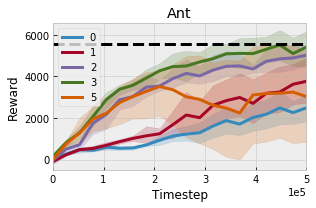

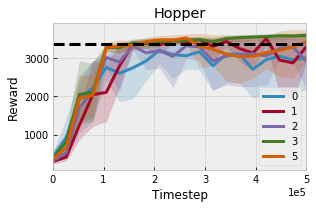

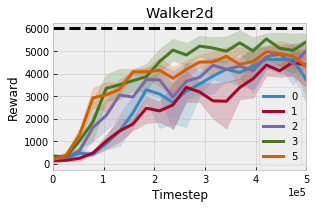

In [24]:
d = '../../dcem2/exp/2020.02.03/1551_ac_mbpo_horizon_sweep/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
# display(agg)
# plot_agg(all_summary, agg)

env_raws = ['mbpo_ant', 'mbpo_hopper', 'mbpo_walker2d']
env_pretties = ['Ant', 'Hopper', 'Walker2d']
sac_lims = [5539.33, 3365.3947607517816, 6014.782789806152]

vanilla_sac_exps = {}
sac_3_exps = {}
for env, env_pretty, sac_lim in zip(env_raws, env_pretties, sac_lims):
    groups = []
    for H in [0,1,2,3,5]:
        I = (all_summary['env_cfg'] == env) & (all_summary['agent.params.horizon'] == str(H))
        t = all_summary[I]
        groups.append({
            'roots': t.d.values,
            'tag': str(H),
        })
        if H == 0:
            vanilla_sac_exps[env] = groups[-1]
        elif H == 3:
            sac_3_exps[env] = groups[-1]

    plot_ablation(
        groups = groups,
        save=f'../data/fig/horizon_ablation_{env}.pdf',
        title=env_pretty,
        xmax=5e5,
        legend=True,
        sac_lim=sac_lim
    )

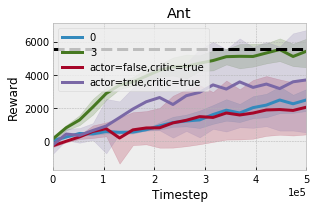

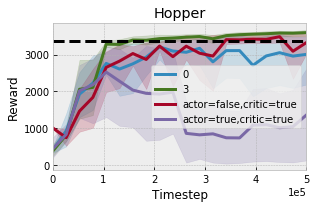

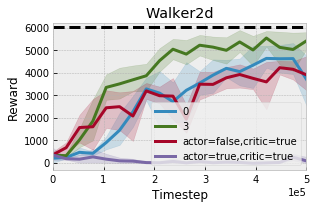

In [25]:
# d = '../exp/2020.02.04/0804_ac_mbpo_mve_sweep/'
d = '../../dcem2/exp/2020.02.05/1321_ac_mbpo_mve_sweep/'
all_summary, groups, agg, configs = sweep_summary(d)
# display(all_summary)
# display(agg)
# plot_agg(all_summary, agg)

bmh_colors = [v['color'] for v in list(plt.style.library['bmh']['axes.prop_cycle'])]

for env, env_pretty, sac_lim in zip(env_raws, env_pretties, sac_lims):
    sac_3_exps[env]['color'] = bmh_colors[3]
    groups = [vanilla_sac_exps[env], sac_3_exps[env]]
    for actor_mve in ['false', 'true']:
        for critic_mve in ['false', 'true']:
            if critic_mve == 'false':
                continue
            I = (all_summary['env_cfg'] == env) & \
                (all_summary['agent.params.actor_mve'] == actor_mve) & \
                (all_summary['agent.params.critic_target_mve'] == critic_mve)
            t = all_summary[I]
            groups.append({
                'roots': t.d.values,
                'tag': f'actor={actor_mve},critic={critic_mve}',
            })

    plot_ablation(
        groups = groups,
        save=f'../data/fig/mve_ablation_{env}.pdf',
        title=env_pretty,
        xmax=5e5,
        legend=True,
        sac_lim=sac_lim,
    )

KeyError: 'step'

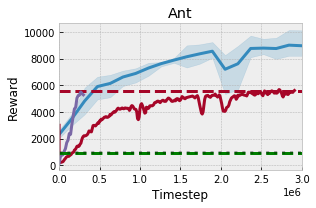

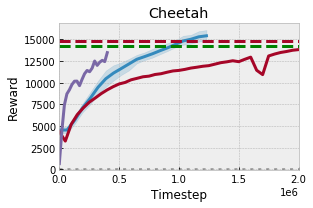

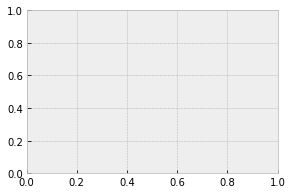

In [21]:
def plot_comparison(
    ac_base, ac_is, mbpo_f, sac_f, title, xmax=None,
    sac_scale=1., steve=None, cb=None, save=None, lw=3,
    xlabel='Timestep', ylabel='Reward', alive_bonus=None,
    n_interp=20, n_smooth=10
):
    fig, ax = plt.subplots(1, 1, figsize=(4.5,3))

    all_df = []
    min_step = None
    for i in ac_is:
        eval_f = f'{ac_base}/{i}/eval.csv'
        df = pd.read_csv(eval_f)
        if min_step is None or max(df['step']) < min_step:
            min_step = max(df['step'])
        df['f'] = eval_f
        all_df.append(df)

    step_interp = np.linspace(0, min_step, num=n_interp)
    all_df_interp = []
    for df in all_df:
        step, rew = df['step'], df['episode_reward']
        step = step[n_smooth-1:]
        rew = np.convolve(rew, np.full(n_smooth, 1./n_smooth), mode='valid')
        rew_interp = np.interp(step_interp, step, rew)
        df_interp = pd.DataFrame({'step': step_interp, 'rew': rew_interp})
        all_df_interp.append(df_interp)
    all_df_interp = pd.concat(all_df_interp)
    sns.lineplot(x='step', y='rew', data=all_df_interp, ax=ax, linewidth=lw)

    sac_data = np.loadtxt(sac_f, delimiter=',').T
    init_cost = np.expand_dims(np.array([0., all_df_interp.iloc[0].rew]), 1)
    
    sac_data = np.hstack((init_cost, sac_data))
    sac_data[1] = sac_scale*sac_data[1] # Correcting the reconstruction of their data
    l, = ax.plot(1e6*sac_data[0], sac_data[1], linewidth=lw)
    ax.axhline(sac_data[1][-3:].mean(), linestyle='--', color=l.get_color(), linewidth=lw)

    mbpo_data = pkl.load(open(mbpo_f, 'rb'))
    mbpo_data['step'] = mbpo_data['x']*1e3
#     ax.plot(mbpo_data['step'], mbpo_data['y'], linewidth=lw)
    min_step = min(max(mbpo_data['step']), min_step)
    step_interp = np.linspace(0, min_step, num=20)
    mbpo_interp = np.interp(step_interp, mbpo_data['step'], mbpo_data['y'])
    ax.plot(step_interp, mbpo_interp, linewidth=lw)
    
    if steve is not None:
        ax.axhline(steve, linestyle='--', color='g', linewidth=lw)
    
    if alive_bonus is not None:
        ax.axhline(alive_bonus, linestyle='dotted', color='k', linewidth=lw, alpha=0.3)

    if cb is not None:
        cb(ax)

    # ax.set_xscale('log')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    if xmax is not None:
        ax.set_xlim(0, xmax)

    ax.set_xlabel('Timestep')
    ax.set_ylabel('Reward')
    ax.set_title(title)
    fig.tight_layout()
    
    if save is not None:
        fig.savefig(save)
        os.system(f'convert -trim {save} {save}')

plot_comparison(
    ac_base='../exp/attic/ant',
    ac_is=['4.1', '4.2', '4.3', '4.4'],
    mbpo_f='../data/mbpo/ant_mbpo.pkl',
    sac_f='../data/sac/ant.csv',
    save='../data/fig/mbpo_ant.pdf',
    title='Ant',
    xmax=3e6,
    steve=(2000./4.)*1.8,
    sac_scale=5.5/5.1,
    alive_bonus=1000.,
)

d = '../exp/2020.05.04/1703_mbpo_others/'
plot_comparison(
    ac_base=d,
    ac_is=[f'58.{i}' for i in range(1,4+1)],
    mbpo_f='../data/mbpo/cheetah_mbpo.pkl',
    sac_f='../data/sac/cheetah.csv',
    save='../data/fig/mbpo_cheetah.pdf',
    title='Cheetah',
    xmax=2e6,
    steve=14200,
    sac_scale=15000/14000,
    alive_bonus=0.,
)


# d = '../exp/2020.05.04/1703_mbpo_others/'
d = '../exp/2020.05.09/1525_sac_mve_mbpo_10'
plot_comparison(
    ac_base=d,
    ac_is=[f'{i}' for i in range(0,7+1)],
    mbpo_f='../data/mbpo/hopper_mbpo.pkl',
    sac_f='../data/sac/hopper.csv',
    save='../data/fig/mbpo_hopper.pdf',
    title='Hopper',
    xmax=1e6,
    steve=(3000./5.)*2.3,
    alive_bonus=1000.,
)

d = '../exp/2020.05.04/1703_mbpo_others/'
plot_comparison(
    ac_base=d,
    ac_is=[f'24.{i}' for i in range(1,4+1)],
    mbpo_f='../data/mbpo/walker2d_mbpo.pkl',
    sac_f='../data/sac/walker.csv',
    save='../data/fig/mbpo_walker.pdf',
    title='Walker2d',
    xmax=1e6,
    steve=(4000./5.)*2,
    alive_bonus=1000.,
)

plot_comparison(
    ac_base='../exp/attic/humanoid',
    ac_is=['19.1', '19.2', '19.3', '19.4'],
    mbpo_f='../data/mbpo/humanoid_mbpo.pkl',
    sac_f='../data/sac/humanoid.csv',
    save='../data/fig/mbpo_humanoid.pdf',
    title='Humanoid',
    xmax=5e6,
#     xmax=1.4e6,
    steve=5800,
    alive_bonus=5000.,
)